<a href="https://colab.research.google.com/github/je-santos/MPLBM-UT/blob/master/examples/create_2D_training_data_4NN/VelNet_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vel-net

## by Javier and Bernard

### (some cool banner goes here)
--------------
## Table of contents
- XXX. Libraries and examples
- Data visualization
- Data analysis
- Simplier methods: Linear regression
- Intro to NN: parabolic profile
- Intro to convnets

In [13]:
# @title Importing libraries and downloading data (run me first)
%%capture

!pip install git+https://github.com/je-santos/livelossplot

import os
import sys
import random

# Importing the numerical and viz libs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon
import seaborn as sns
from IPython.display import clear_output
import ipywidgets as widgets
from IPython.display import display

# Importing utilities libs 
import glob
from PIL import Image

# Importing the ML libs
import sklearn
import tensorflow as tf
from tensorflow import keras
#keras.backend.set_epsilon = 1e-4


from livelossplot import PlotLossesKeras
from livelossplot.plot_losses  import MatplotlibPlot
    
import warnings
warnings.simplefilter("ignore")

try:
  os.mkdir('numpys')
except:
  pass 


!git clone https://github.com/je-santos/PoreFlow-Net.git
!mv PoreFlow-Net/ilustrations/numpys.zip numpys/numpys.zip
os.chdir('numpys')


from zipfile import ZipFile
with ZipFile('numpys.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()
os.chdir('..')




  Cloning https://github.com/je-santos/livelossplot to c:\users\jae3287\appdata\local\temp\pip-req-build-sfhdmdwc
  Created wheel for livelossplot: filename=livelossplot-0.5.0-py3-none-any.whl size=20505 sha256=4c340433a172dccf067eb966933e218c273278069fe2c476de0ad1a8900dee6c
  Stored in directory: C:\Users\jae3287\AppData\Local\Temp\pip-ephem-wheel-cache-d_03udjz\wheels\d1\85\7f\91c563589b9efae46dcb114d7983ea917ecaa1f37efb85023c
Successfully built livelossplot


fatal: destination path 'PoreFlow-Net' already exists and is not an empty directory.
'mv' is not recognized as an internal or external command,
operable program or batch file.


# Introduction:
...

...

## What's a neuron?

A neuron performs a mathematical operation where the input data ($x$) is multiplied by a $\textit{weight}$ ($w$) followed by the addition of a $\textit{bias term}$ ($b$). These are called $\textit{trainable parameters}$.

$y=x*w+b$

Additionally, this ouput  can passed through a non-linear activation function.

$y_{_{NL}} = f(y)$

Some examples of non-linearities commonly used in NN are the following:

- $ReLU(y)     = max(0, y)$

- $sigmoid(y) = 1 / (1 + exp(-y))$

Each function has distint properties that can benefit certain applications.

IntRangeSlider(value=(-2, 2), description='Input range:', max=10, min=-10)

FloatSlider(value=-0.1, description='Weight value:', max=5.0, min=-5.0)

FloatSlider(value=0.0, description='Bias value:', max=5.0, min=-5.0)

RadioButtons(description='Activation:', index=1, options=('linear', 'sigmoid', 'ReLU'), value='sigmoid')

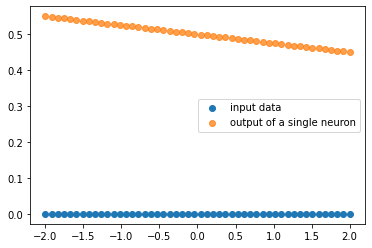

In [11]:
# @title A single neuron

xi = widgets.IntRangeSlider()
xi.min = -10
xi.max =  10
xi.value= [-2, 2]
xi.description='Input range:'
display(xi)


w = widgets.FloatSlider()
w.value= 1
w.min = -5
w.max =  5
w.description='Weight value:'
display(w)

b = widgets.FloatSlider()
b.value= 0
b.min = -5
b.max =  5
b.description='Bias value:'
display(b)

act = widgets.RadioButtons()
act.options=['linear','sigmoid','ReLU']
act.description = 'Activation:'
display(act)

    
def plot_w(*args):
#def plot_w(xi=xi,w=w,b=b,act=act):
    print(f'Hi my first value is {xi.value[0]}')
    x_t = np.linspace(xi.value[0],xi.value[1])
    y_t = x_t*w.value+b.value
    if act.value=='sigmoid':
        y_t = 1 / (1 + np.exp(-y_t))
    if act.value=='ReLU':
        y_t = np.maximum(y_t,0)

    #plt.figure(1)
    #plt.close()
    clear_output(wait=True)
    display(xi,w,b,act)
    plt.scatter(x_t, np.zeros_like(x_t))
    plt.scatter(x_t, y_t,alpha=0.75)
    plt.legend(['input data','output of a single neuron'])
    plt.show()

plot_w()
    
xi.observe(plot_w,'value')
w.observe(plot_w,'value')
b.observe(plot_w,'value')
act.observe(plot_w,'value')


## How does a neuron learn?

The the values of the neuron's weight ($w$) and  bias ($b$) are adjusted (or trained) based on the training data provided. These parameters are trained by minimizing the function:

$Loss = loss\_f(y\_pred, y\_true)$

Intuitively, this process can be seen as minimizing the error (or mismatch) of the training data with the ouput of the neural network. Common loss functions ($\textit{$loss\_f$}$) for inference include mean squared error and mean absolute error, and binary crossentrophy for segmentation.

## What happens when we use multiple neurons? 


![image here](https://raw.githubusercontent.com/je-santos/MPLBM-UT/master/illustrations/playground.png)

Let's go to: https://playground.tensorflow.org

## Problem 1: Flow through a tube

In [112]:
""""This is our target function, the neural network doesn't know this"""

def vel_profile(x):
    return 1-x**2
x_vel = np.linspace(-1,1,100)
y_vel = vel_profile(x_vel)

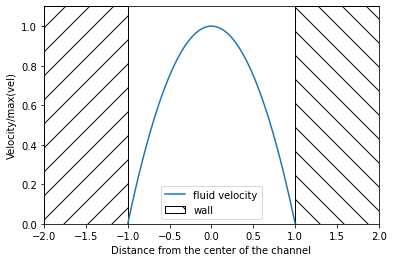

In [50]:
fig, ax = plt.subplots(1)
ax.plot(x_vel,y_vel)
ax.axes.add_patch(Polygon([[1, 0], [2, 0], [2, 1.1],[1, 1.1]], closed=True,
                      fill=False, hatch='\ '))
ax.axes.add_patch(Polygon([[-1, 0], [-2, 0], [-2, 1.1],[-1, 1.1]], closed=True,
                      fill=False, hatch='/'))
plt.xlim([-2,2])
plt.ylim([0,1.1]);
plt.xlabel('Distance from the center of the channel')
plt.ylabel('Velocity/max(vel)');
plt.legend(['fluid velocity','wall']);

## Training our first neural network
We'll start with the simplest neural network architecture. A model with one neuron, which is equivalent to a linear regression:

$y=x*w_1+b_1$

We will use mean square error:

$MSE(y\_pred,y)=\frac{1}{N}\sum(y\_pred-y)^2$

and the ADAM optimizer:

$\theta_{t+1} = \theta_{t}-LR\frac{v_t}{\sqrt{s_t+\epsilon}}\cdot g_t$

Where $v_t$ and $s_t$ are the first and second gradient moments respectively  

In [102]:
model_name = 'nn_class'
rnd_seed   = np.sum( [ord(letter) for letter in model_name] )*123123
np.random.seed( rnd_seed )    # we use this num as the rnd seed for numpy

In [51]:
# Defining our default parameters
loss_f  = 'mse'
optim   = keras.optimizers.Adam
LR      = 0.001
metrics = 'MAPE' #Mean average percentage error

In [52]:
# Setting up our model using the keras library
linear_model = keras.Sequential([keras.layers.Dense(1,input_shape=[1])])
linear_model.compile(loss=loss_f,optimizer=optim(), metrics=metrics)
linear_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


We have 2 trainable parameters: one weight and one bias

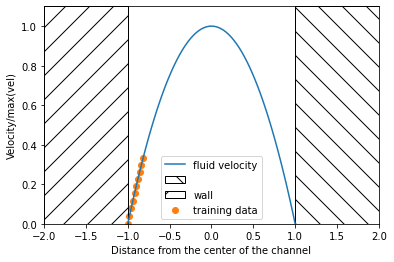

In [53]:
fig, ax = plt.subplots(1)
ax.plot(   x_vel,     y_vel)
ax.scatter(x_vel[:10],y_vel[:10],c='tab:orange')
ax.axes.add_patch(Polygon([[1, 0], [2, 0], [2, 1.1],[1, 1.1]], closed=True,
                      fill=False, hatch='\ '))
ax.axes.add_patch(Polygon([[-1, 0], [-2, 0], [-2, 1.1],[-1, 1.1]], closed=True,
                      fill=False, hatch='/'))
plt.xlim([-2,2])
plt.ylim([0,1.1]);
plt.xlabel('Distance from the center of the channel')
plt.ylabel('Velocity/max(vel)');
plt.legend(['fluid velocity','','wall','training data']);

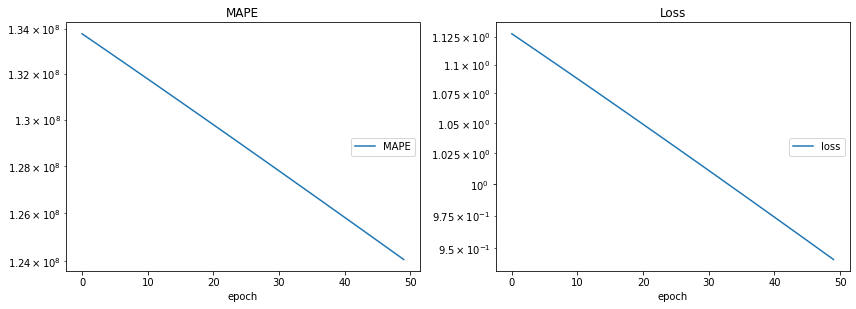

MAPE
	MAPE             	 (min: 124079536.000, max: 133772592.000, cur: 124079536.000)
Loss
	loss             	 (min:    0.941, max:    1.127, cur:    0.941)
1/1 [==============================] - 0s 470ms/step - loss: 0.9415 - MAPE: 124079536.0000


In [54]:
linear_model.fit(x=x_vel[:10], y=y_vel[:10], callbacks=PlotLossesKeras(), epochs=50, validation_split=0)

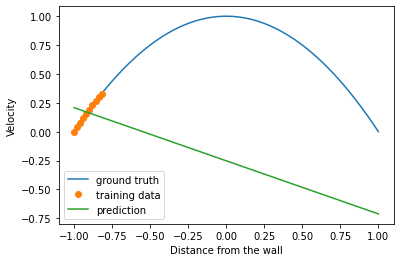

In [66]:
y_pred = linear_model.predict(x=x_vel)

plt.plot(x_vel,y_vel)
plt.plot(x_vel[:10], y_vel[:10],'o')
plt.plot(x_vel, y_pred)

plt.legend(['ground truth','training data','prediction'])
plt.xlabel('Distance from the center of the channel')
plt.ylabel('Velocity');

In [73]:
keras.backend.set_value(linear_model.optimizer.learning_rate, 1)

KeyboardInterrupt: 

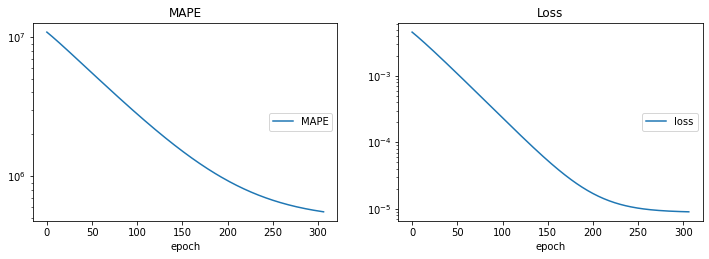

In [74]:
linear_model.fit(x=x_vel[:10], y=y_vel[:10], callbacks=PlotLossesKeras(), epochs=1000, validation_split=0)

A good place to stop training is when MSE < 1e-5

In [ ]:
y_pred = linear_model.predict(x=x_vel)

Text(0.5, 1.0, 'NN result close to the training data')

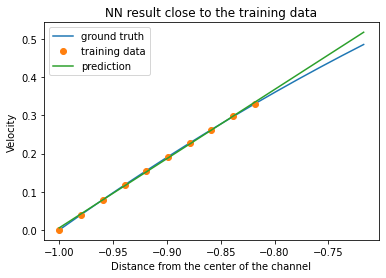

In [79]:
plt.plot(x_vel[:15],y_vel[:15])
plt.plot(x_vel[:10], y_vel[:10],'o')
plt.plot(x_vel[:15], y_pred[:15])

plt.legend(['ground truth','training data','prediction'])
plt.xlabel('Distance from the center of the channel')
plt.ylabel('Velocity');
plt.title('NN result close to the training data')

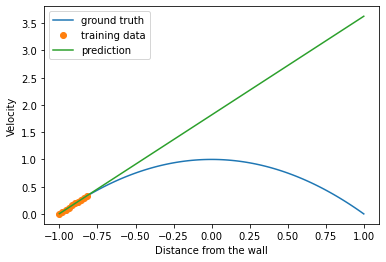

In [80]:
plt.plot(x_vel,y_vel)
plt.plot(x_vel[:10], y_vel[:10],'o')
plt.plot(x_vel, y_pred)

plt.legend(['ground truth','training data','prediction'])
plt.xlabel('Distance from the center of the channel')
plt.ylabel('Velocity');

hmmm that is still not great. Let's try to get a more representative training set.

In [82]:
IDs = np.arange( x_vel.shape[0] ) 
np.random.shuffle( IDs )
x_train = x_vel[IDs[:10]]
y_train = y_vel[IDs[:10]]

In [89]:
linear_model.compile(loss=loss_f,optimizer=optim(), metrics=metrics)

In [96]:
keras.backend.set_value(linear_model.optimizer.learning_rate, 0.01)

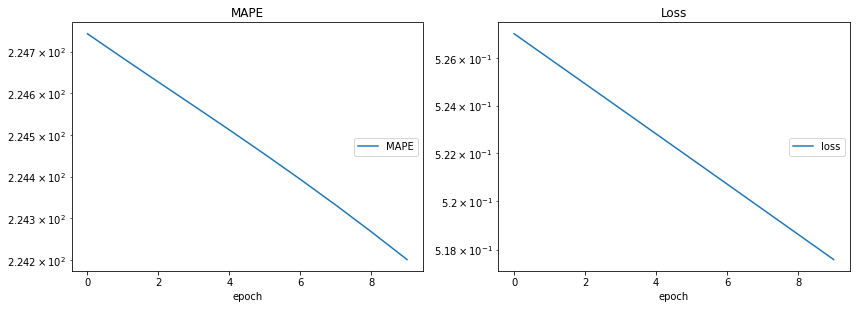

MAPE
	MAPE             	 (min:  224.201, max:  224.743, cur:  224.201)
Loss
	loss             	 (min:    0.518, max:    0.527, cur:    0.518)
1/1 [==============================] - 0s 436ms/step - loss: 0.5176 - MAPE: 224.2009


In [130]:
linear_model.fit(x=x_train, y=y_train, callbacks=PlotLossesKeras(), epochs=10, validation_split=0)

In [98]:
y_pred = linear_model.predict(x=x_vel)

Text(0, 0.5, 'Velocity')

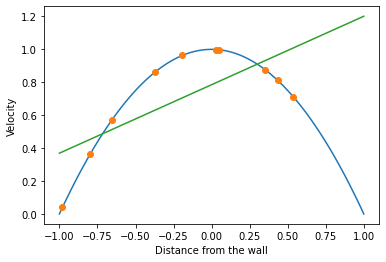

In [99]:
plt.plot(x_vel,y_vel)
plt.plot(x_train, y_train,'o')
plt.plot(x_vel, y_pred)

plt.xlabel('Distance from the center of the channel')
plt.ylabel('Velocity')

In [100]:
non_linear_model = keras.Sequential()
non_linear_model.add(keras.layers.Dense(2,activation='selu',input_shape=[1]))
non_linear_model.add(keras.layers.Dense(1,activation='selu'))
non_linear_model.compile(loss=loss_f,optimizer=optim(), metrics=metrics)
non_linear_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2)                 4         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


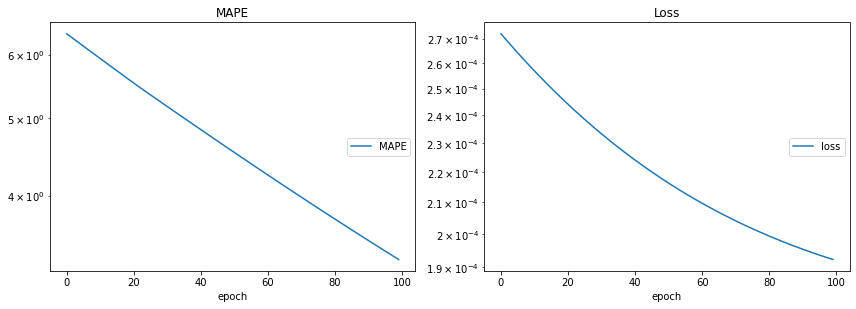

MAPE
	MAPE             	 (min:    3.328, max:    6.369, cur:    3.328)
Loss
	loss             	 (min:    0.000, max:    0.000, cur:    0.000)
1/1 [==============================] - 0s 464ms/step - loss: 1.9230e-04 - MAPE: 3.3282


In [115]:
keras.backend.set_value(non_linear_model.optimizer.learning_rate, 0.1)
non_linear_model.fit(x=x_train, y=y_train, callbacks=PlotLossesKeras(), epochs=100, validation_split=0)

A good place to stop training is when MSE < 1e-4

In [116]:
y_pred_NL = non_linear_model.predict(x=x_vel)

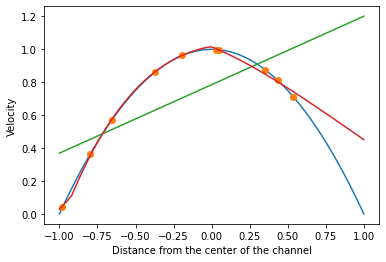

In [118]:
plt.plot(x_vel,y_vel)
plt.plot(x_train, y_train,'o')
plt.plot(x_vel, y_pred)
plt.plot(x_vel, y_pred_NL)


plt.xlabel('Distance from the center of the channel')
plt.ylabel('Velocity');

## Scientific machine-learning
What if we knew something about the data itself?
For example, if we knew that our dataset was comprised by parabolic profiles, we could add that to our neural network arquitecture


In [129]:
def build_linear_model(input_shape):
    inputs = keras.layers.Input(shape=input_shape)
    path   = keras.backend.square(inputs)
    path   = keras.layers.Dense(1,activation='linear')(path)
    return keras.models.Model(inputs, path)
    #return keras.models.Model(inputs=inputs, output=path)
    
linear_model = build_linear_model( input_shape=1)
linear_model.compile(loss=loss_f,optimizer=optim(), metrics=metrics)

In [143]:
# let's give it the "hard" traing data
x_train = x_vel[:10]
y_train = y_vel[:10]

In [144]:
keras.backend.set_value(linear_model.optimizer.learning_rate, 0.1)

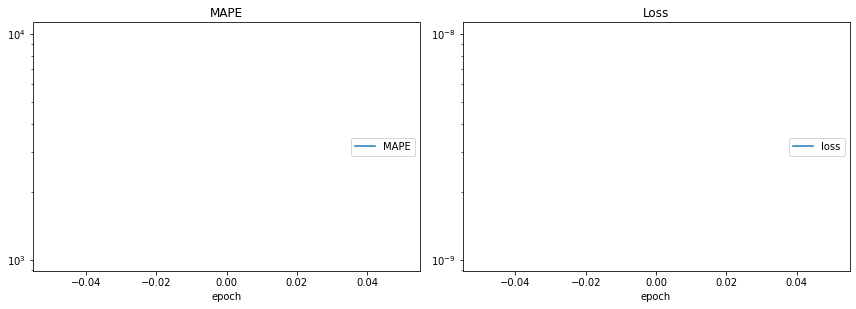

MAPE
	MAPE             	 (min: 8136.065, max: 8136.065, cur: 8136.065)
Loss
	loss             	 (min:    0.000, max:    0.000, cur:    0.000)
1/1 [==============================] - 0s 431ms/step - loss: 3.1551e-09 - MAPE: 8136.0654


In [146]:
linear_model.fit(x=x_train, y=y_train, callbacks=PlotLossesKeras(), epochs=1, validation_split=0)

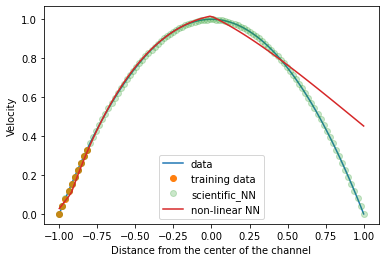

In [147]:
y_pred = linear_model.predict(x=x_vel)
plt.plot(x_vel,y_vel)
plt.plot(x_train, y_train,'o')
plt.plot(x_vel, y_pred, 'o', alpha=0.25)
plt.plot(x_vel, y_pred_NL)

plt.legend(['data','training data','scientific_NN','non-linear NN'])
plt.xlabel('Distance from the center of the channel')
plt.ylabel('Velocity');

## What about 3D data?

In [153]:
def profile_3D(x,y):
    return 1-(x**2 + y**2)

In [167]:
model = keras.Sequential() # as first layer in a sequential model:
# let's define our first 3D model (there is still room from creativity here)
model.add( keras.layers.Dense( units=20, input_shape=(2,) ) )
model.add( keras.layers.Activation(activation='selu') )
model.add( keras.layers.Dense( units=20, input_shape=(20,) ) )
model.add( keras.layers.Activation(activation='selu') )
model.add( keras.layers.Dense( units=1, input_shape=(20,) ) )
model.compile(loss=loss_f,optimizer=optim(), metrics=metrics)

In [158]:
x1 = np.array([-1, -1, 0.5, -0.5, 0.1, 0.2, 0.45, 0.9, -0.8,0,1,-1])
x2 = np.array([1, 1, -0.5, 0.5, -0.1, -0.2, -0.45, -0.9, 0.8, 0,1,-1])
y  = profile_3D(x1,x2)

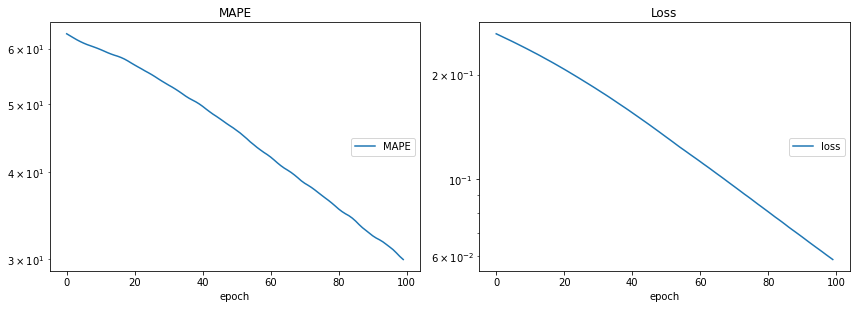

MAPE
	MAPE             	 (min:   29.998, max:   63.058, cur:   29.998)
Loss
	loss             	 (min:    0.059, max:    0.262, cur:    0.059)
1/1 [==============================] - 0s 432ms/step - loss: 0.0586 - MAPE: 29.9982


In [175]:
%matplotlib inline
model.fit(np.stack([x1,x2]).T, y, epochs=100, callbacks=PlotLossesKeras())

In [176]:
x1_test = (np.random.rand(100)-0.5)*2
x2_test = (np.random.rand(100)-0.5)*2
y_true  = profile_3D(x1_test, x2_test)
y_pred  = model.predict(np.stack([x1_test,x2_test]).T).reshape(-1)

<IPython.core.display.Javascript object>


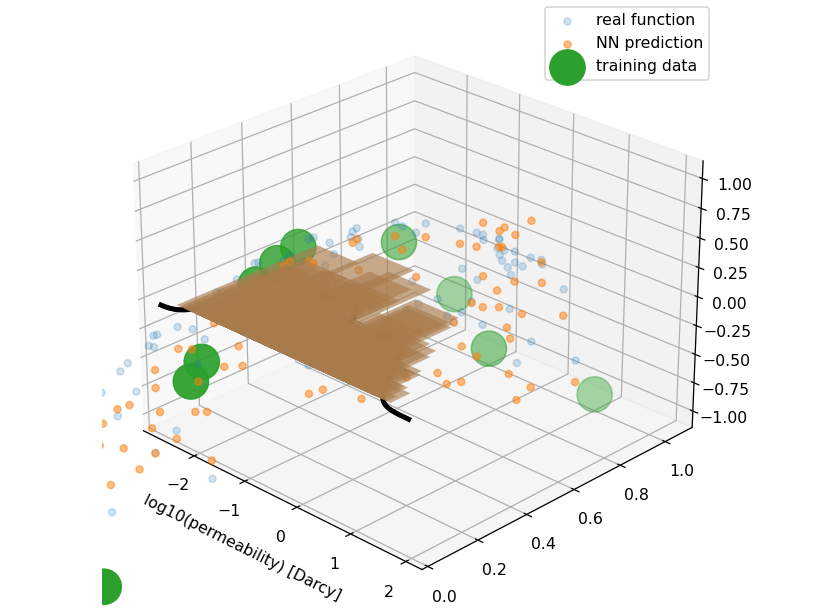

In [177]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x1_test, x2_test, y_true, alpha=0.2)
ax.scatter(x1_test, x2_test, y_pred, alpha=0.5)
ax.scatter(x1,x2,y, s=500)
plt.legend(['real function', 'NN prediction','training data'])

## Problem 2: Permeability prediction
...

...

## Loading the data

In [186]:
# load the file
X = np.load('numpys/X.npy')
y = np.load('numpys/y.npy').astype(np.float32)

k   = np.mean(y, axis=(1,2))*100000 #normalize the permeability

# data cleaning (remove non-percolating samples)
def drop_samples(x,ind):
    return x[ind]

indices = np.where(k>0.01) # drop the samples where the permeability is lower than 0.01 [D]
X,y,k   = [drop_samples(array,indices) for array in [X,y,k]]


phi = 1-np.mean(X, axis=(1,2)) # calculating the porosity

In [187]:
print(f'The shape of X is {X.shape} and the shape of y is {y.shape}')
print('                  (Number of examples, x and y)')
print()
print(f'The average porosity is {np.mean(phi)*100:4.2f}% and the average permeability is {np.mean(k):0.2} [Darcy]')

The shape of X is (792, 128, 256) and the shape of y is (792, 128, 256)
                  (Number of examples, x and y)

The average porosity is 44.32% and the average permeability is 1.3 [Darcy]


## Data visualization

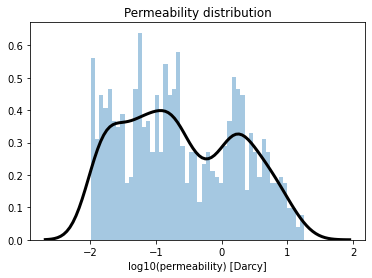

In [189]:
%matplotlib inline
sns.distplot(np.log10(k),bins=50, kde_kws={"color": "k", "lw": 3})
plt.title('Permeability distribution')
plt.xlabel('log10(permeability) [Darcy]');

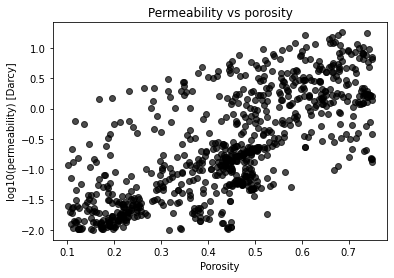

In [190]:
plt.scatter(phi,np.log10(k),c='k',alpha=0.7)
plt.title('Permeability vs porosity')
plt.ylabel('log10(permeability) [Darcy]')
plt.xlabel('Porosity');

IntSlider(value=141, description='Im number', max=792)

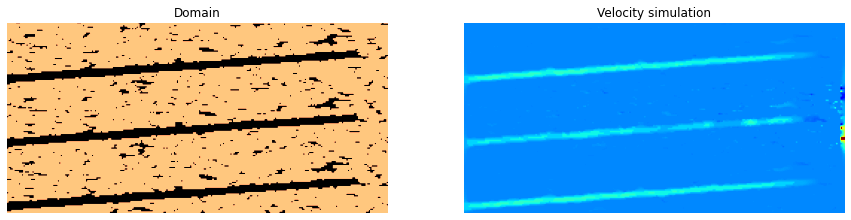

In [191]:
w = widgets.IntSlider()
w.value= 0
w.min =  0
w.max =  X.shape[0]
w.description='Im number'
display(w)

def plot_im(*args):
    clear_output(wait=True)
    display(w)
    
    #plt.figure(dpi=300)
    plt.subplot(1,2,1)
    plt.imshow(X[w.value], cmap='copper', clim=(0,.75))
    plt.axis('off')
    plt.title('Domain')
    plt.subplot(1,2,2)
    plt.imshow(y[w.value], cmap='jet')
    plt.axis('off')
    plt.title('Velocity simulation')
    
    fig = plt.gcf() 
    fig.set_size_inches(15,6)
    
plot_im()
w.observe(plot_im,'value')

## Splitting our data
To assess the predictive capabilites of our models we split our data into training and testing. The training data will be seen by the model and will be used to update its internal parameters to reduce the error. The test data will be used to assess how good is the trained model.

In [192]:
split      = 0.8 # fraction of the data that will be used for training
num_train  = int(split*X.shape[0]) # num of samples for training 
print(f'Total samples in the data set: {X.shape[0]}, we will use {num_train} for training')

Total samples in the data set: 792, we will use 633 for training


In [193]:
def shuffle_samples(x,IDs,num_train):
    return x[IDs[:num_train]],x[IDs[num_train:]]

IDs = np.arange( X.shape[0] ); np.random.shuffle( IDs )
[X_train,X_test],[y_train,y_test],[phi_train,phi_test],[k_train,k_test] = \
                        [shuffle_samples(array,IDs, num_train) for array in [X,y,phi,k]]

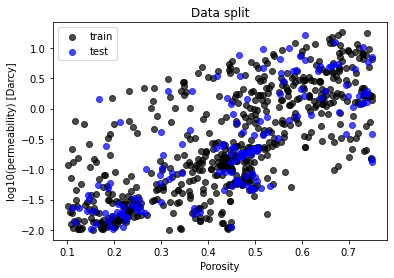

In [194]:
plt.scatter(phi_train,np.log10(k_train),c='k',alpha=0.7)
plt.scatter(phi_test ,np.log10(k_test) ,c='b',alpha=0.7)
plt.legend(['train','test'])
plt.title('Data split')
plt.ylabel('log10(permeability) [Darcy]')
plt.xlabel('Porosity');

## Normalizing our data

In [195]:
k_train_mean = np.mean(k_train)
k_train_std  = np.std( k_train)

phi_train_mean = np.mean(phi_train)
phi_train_std  = np.std( phi_train)

k_train = (k_train-k_train_mean)/k_train_std
k_test  = (k_test -k_train_mean)/k_train_std

phi_train = (phi_train-phi_train_mean)/phi_train_std
phi_test  = (phi_test -phi_train_mean)/phi_train_std

In [196]:
print(f'The mean of k_train is {k_train.mean():0.2} and the std {k_train.std()}')

The mean of k_train is 2.2e-17 and the std 1.0


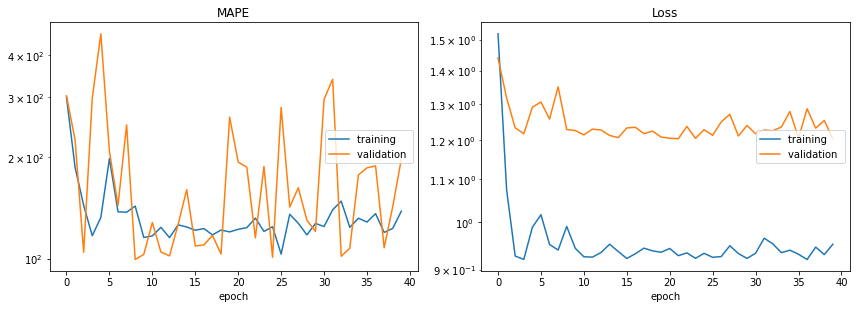

MAPE
	training         	 (min:  103.264, max:  300.108, cur:  138.294)
	validation       	 (min:   99.554, max:  462.589, cur:  197.015)
Loss
	training         	 (min:    0.920, max:    1.519, cur:    0.952)
	validation       	 (min:    1.203, max:    1.440, cur:    1.203)
16/16 [==============================] - 1s 46ms/step - loss: 0.9522 - MAPE: 138.2935 - val_loss: 1.2033 - val_MAPE: 197.0150


In [197]:
linear_model.fit(x=phi_train, y=k_train, callbacks=PlotLossesKeras(), epochs=40, validation_split=0.2)

In [198]:
def rel_errror(y,y_pred,epsilon=1e-4, reduction = 'mean'):
    rel_error = np.abs(y-y_pred)/np.clip(np.abs(y),a_min=epsilon,a_max=None)*100 
    if reduction == 'mean':
        return rel_error.mean()
    elif reduction == 'none':
        return rel_error()

268.2527236060331


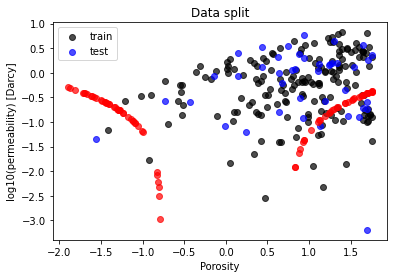

In [199]:
k_linear     = linear_model.predict(x=phi_test)
error_linear = rel_errror(k_test,k_linear)
print(error_linear)

plt.scatter(phi_train,np.log10(k_train),c='k',alpha=0.7)
plt.scatter(phi_test ,np.log10(k_test) ,c='b',alpha=0.7)
plt.scatter(phi_test ,np.log10(k_linear),c='r',alpha=0.7)
plt.legend(['train','test'])
plt.title('Data split')
plt.ylabel('log10(permeability) [Darcy]')
plt.xlabel('Porosity');

In [ ]:
non_linear_model.fit(x=phi_train, y=k_train, callbacks=PlotLossesKeras(), epochs=100, validation_split=0.2)

In [ ]:
k_nonlinear     = non_linear_model.predict(x=phi_test)
error_linear = rel_errror(k_test,k_nonlinear)
print(error_linear)

plt.scatter(phi_train,np.log10(k_train),c='k',alpha=0.7)
plt.scatter(phi_test ,np.log10(k_test) ,c='b',alpha=0.7)
plt.scatter(phi_test ,np.log10(k_linear),c='r',alpha=0.7)
plt.scatter(phi_test ,np.log10(k_nonlinear),c='g',alpha=0.7)
plt.legend(['train','test'])
plt.title('Data split')
plt.ylabel('log10(permeability) [Darcy]')
plt.xlabel('Porosity');